# 1. Import Libraries 

In [1]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import cv2

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import MDS, TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'
kg_vec = 600

In [2]:
%load_ext autoreload
%autoreload 2

# 2. Import Data

In [3]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'Word2Vec Extended', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom KG Extended 01" - Custom KGs with ontology alignment
#3. "Custom KG Extended 02" - Custom KGs with ontology alignment + vector combination
#4. "Word2Vec" - word2vec-google-news-300
#4. "Word2Vec Extended" - Extended Word2Vec
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)
#7. "WordNet" - WordNet Knowledge Graph (KGVec2Go WordNet)
#8. "Custom Animal Attribute KG Extended" - Extended Custom KGs


Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Word2Vec Animal Attributes Extended Included
Execution time: 9.973717212677002 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [4]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [5]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,-kg_vec:]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,-kg_vec:]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,-kg_vec:]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,-kg_vec:]

In [6]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [7]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [8]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis


# 7. Set up Neural Network for multilabel classifciation

### 7.1 Define DNN for projection network

In [9]:
class ProjectionNetwork1(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork1, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out   

In [10]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out   

In [11]:
class ProjectionNetwork3(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork3, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, num_units) 
        self.fc4 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out   

### 7.2 Define evaluation criterea and checkpoint for projection network

In [12]:
# Create Skorch EPOCHScoring   
train_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'train_recall_macro', on_train = True)
valid_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'valid_recall_macro', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 7.3 Check for GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### 7.4 Define Conventiona Zero Shot Leaning Function

In [14]:
def CZSL(mode, split, DNN, epochs, bs, numunits, lr, optimiser, dropout, mom, wd, device, checkpoint, pred_type, dist_type):
    torch.manual_seed(0)    
    
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
       
        
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    #Model 01
    net = NeuralNetClassifier(
    DNN,
    batch_size= bs,
    module__num_units = numunits,
    module__non_linear = optimiser,
    module__dropout = dropout,
    max_epochs=epochs,
    lr=lr,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = wd,
    train_split = ValidSplit(5),
    callbacks=[train_macro_recall_score,valid_macro_recall_score, checkpoint],
    callbacks__valid_acc=None,
    device= device
    )     
    
    #Train three models of three Train Val spilts
    print('Training DNN')
    st = time.time()   
    net.fit(X,y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    #Plot training val curves
    print('Training Validation Loss Curve')
    train_loss = net.history[:, 'train_loss']
    valid_loss = net.history[:, 'valid_loss']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('Error Loss', fontsize=10)
    plt.legend()
    plt.show() 
    
    print('Trianing Recall Macro Curve')
    train_loss = net.history[:, 'train_recall_macro']
    valid_loss = net.history[:, 'valid_recall_macro']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('F1 Score (Macro)', fontsize=10)
    plt.legend()
    plt.show() 
    
    #load best model weights
    net.load_params(checkpoint=checkpoint)  
 
    #predict attributes for Seen classes
    if mode == "Train":
        predicted_attributes = net.predict(SeenClassFeatures.astype(np.float32).values)
        #print attribute prediction DNN performance
        #print(classification_report(SeenClassAttributes.astype(np.float32).values, predicted_attributes, target_names=animal_attributes_list))    
        
        print("Recall (Macro)")
        print(recall_score(SeenClassAttributes.astype(np.float32).values, predicted_attributes, average='macro'))
    
    if mode == "Test":
        pass

    #predict attributes for Unseen classes 
    y_pred_unseen = net.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    y_pred_unseen_proba = net.predict_proba(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,-kg_vec:])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('TSNE spatialisation of Unseen Classes')
    
    classes_df = predicatedf_CZSL.copy()
    classes_df.reset_index(inplace=True)
    
    embeddings = TSNE(n_components=2, verbose=0, random_state=123, perplexity=9.0)

    TSNE_predicates = embeddings.fit_transform(animal_attributes) 
    TSNE_predicates_df = pd.DataFrame(data = TSNE_predicates
                 , columns = ['Binary comp-1', 'Binary comp-2'])
    
    TSNE_predicates_df1 = pd.concat([TSNE_predicates_df,classes_df['classes']], axis = 1)
    TSNE_predicates_df1 = TSNE_predicates_df1.merge(taxonomy_df, how = 'inner', left_on = 'classes', right_on = 'animal_class')
    
    #By animal class
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('classes:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='classes:N'
    )

    display(binary_points.interactive() + text1)
    
    #By Taxonomy Family
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('order:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='order:N'
    )

    display(binary_points.interactive() + text1)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseenprob = []
    for y in y_pred_unseen_proba:
        y_pred_unseenprob.append(y[1])
        
    if pred_type == 'Probabilistic':
        dist_CZSL= (1-distance.cdist(y_pred_unseenprob, animal_attributes, dist_type))
    elif pred_type == 'Deterministic':    
        dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order', 'family']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction, normalize = 'true')
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order'], inplace=True)
    train_animal_family = Train_family_labels['order'].unique()
    
    print(classification_report(UnseenData['order'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order'], predicted_taxonomy_df['order'], normalize = 'true')
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        
    return dist_CZSL, animal_attributes_labels, animal_classes    

# 8. Train Model

### 8.1 Train Validation Split 01

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5422                0.4985        0.5188                0.5038     +  3.6584
      2        0.5106                0.5147        0.4964                0.5239     +  1.8227
      3        0.4825                0.5454        0.4633                0.5668     +  1.8097
      4        0.4480                0.5858        0.4290                0.6080     +  1.8313
      5        0.4155                0.6224        0.3985                0.6412     +  1.8623
      6        0.3867                0.6543        0.3713                0.6715     +  2.0819
      7        0.3608                0.6833        0.3466                0.6993     +  1.9131
      8        0.3374                0.7099        0.3244                0.7248     +  1.6637
      9        0.3166                0.7344    

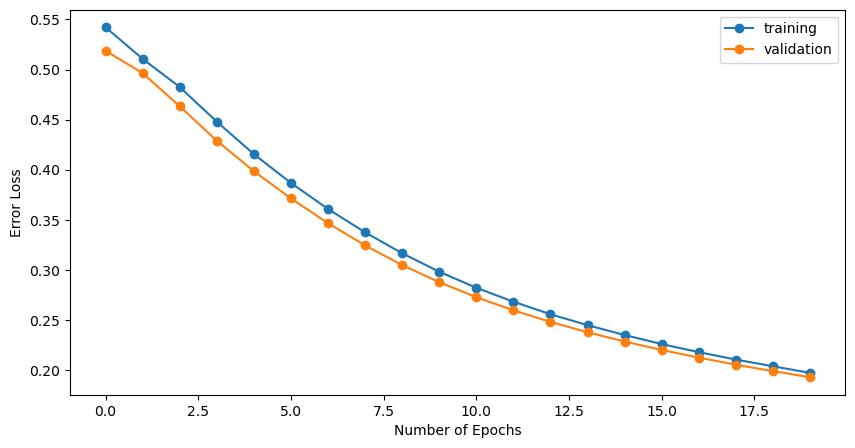

Trianing Recall Macro Curve


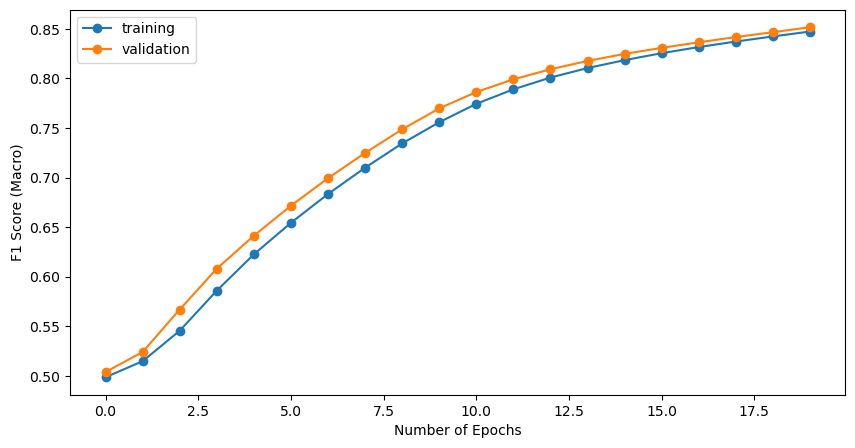

Recall (Macro)
0.8510179836483094
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.02      0.14      0.03       152
   dalmatian       0.26      0.56      0.35       442
        mole       0.00      0.00      0.00        75
     leopard       0.33      1.00      0.50       568
       moose       0.34      0.02      0.04       554
     gorilla       0.38      0.00      0.01       709
          ox       0.40      1.00      0.57       588
  chimpanzee       0.00      0.00      0.00       566
     hamster       0.60      0.16      0.26       640
      rabbit       0.00      0.00      0.00       877
 giant+panda       0.55      0.94      0.70       692
        deer       1.00      0.01      0.03      1069
     raccoon       0.04      0.03      0.03       408

    accuracy                           0.30      7340
   macro avg       0.30      0.30      0.19      7340
weighted avg       0.39      0.30      0.20      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.13815789 0.558823

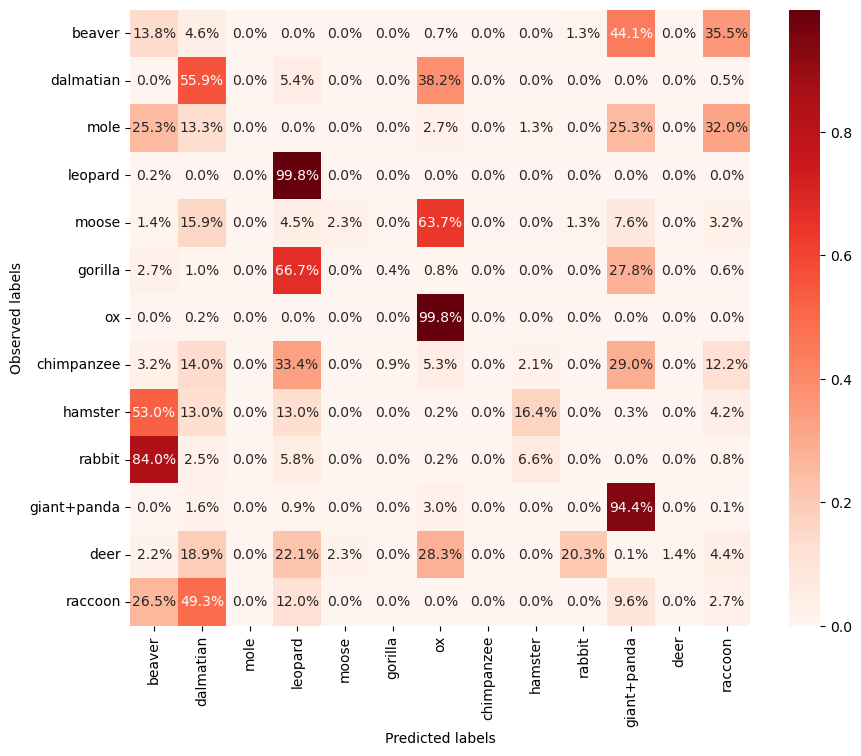

              precision    recall  f1-score   support

ARTIODACTYLA       0.85      0.59      0.69      2211
   CARNIVORA       0.44      0.86      0.58      2110
EULIPOTYPHLA       0.00      0.00      0.00        75
  LAGOMORPHA       0.00      0.00      0.00       877
    PRIMATES       1.00      0.01      0.01      1275
    RODENTIA       0.32      0.59      0.41       792

    accuracy                           0.49      7340
   macro avg       0.43      0.34      0.28      7340
weighted avg       0.59      0.49      0.42      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.58570782 0.85829384 0.         0.         0.00627451 0.58712121]
Top_1_accuracy for UnSeen Validation split 01 -  0.33956623088358134


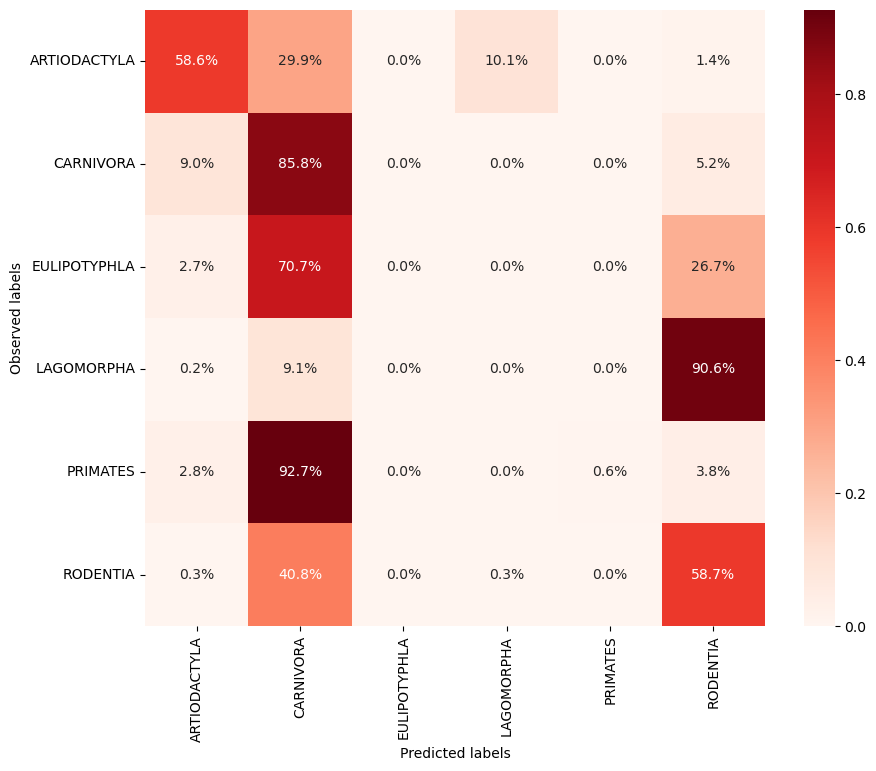

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.44265701416487374 
              0         1
0        beaver  0.276316
1     dalmatian  0.832579
2          mole  0.000000
3       leopard  1.000000
4         moose  0.462094
5       gorilla  0.166432
6            ox  0.998299
7    chimpanzee  0.000000
8       hamster  0.735938
9        rabbit  0.000000
10  giant+panda  0.981214
11         deer  0.169317
12      raccoon  0.132353 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.5374190016404471 
              0         1
0        beaver  0.368421
1     dalmatian  0.891403
2          mole  0.026667
3       leopard  1.000000
4         moose  0.611913
5       gorilla  0.517630
6            ox  0.998299
7    chimpanzee  0.000000
8       hamster  0.951562
9        rabbit  0.002281
10  giant+panda  0.994220
11         deer  0.366698
12      raccoon  0.257353 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.6165187480254323 
              0         1
0        beaver  0.453947
1    

In [15]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.2 Train Validation Split 02

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5381                0.4955        0.5153                0.4964     +  1.7231
      2        0.5079                0.5102        0.4950                0.5158     +  1.8534
      3        0.4820                0.5362        0.4646                0.5493     +  1.8109
      4        0.4482                0.5724        0.4296                0.5910     +  1.7429
      5        0.4134                0.6128        0.3964                0.6323     +  1.7131
      6        0.3817                0.6499        0.3670                0.6679     +  1.8235
      7        0.3543                0.6826        0.3419                0.6981     +  1.9784
      8        0.3306                0.7111        0.3204                0.7241     +  1.7585
      9        0.3105                0.7341    

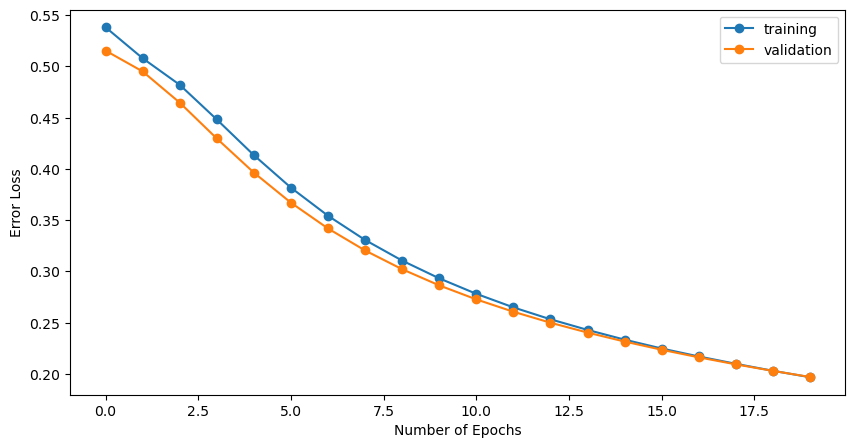

Trianing Recall Macro Curve


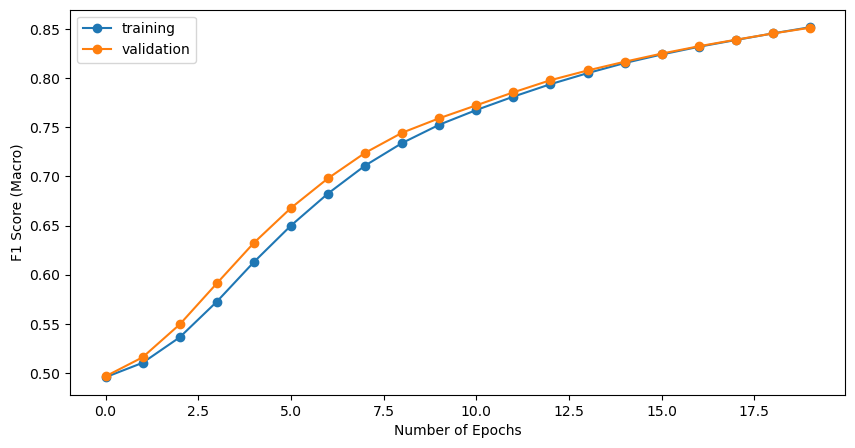

Recall (Macro)
0.8535042075579866
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.73      0.12      0.20       864
grizzly+bear       0.40      0.75      0.52       690
killer+whale       0.69      0.96      0.80       231
      beaver       0.15      0.62      0.24       152
   dalmatian       0.01      0.00      0.00       442
 persian+cat       0.49      0.84      0.62       599
       skunk       0.00      0.00      0.00       157
          ox       0.59      1.00      0.74       588
         fox       0.88      0.62      0.73       540
   chihuahua       0.45      0.79      0.57       448
       otter       0.33      0.00      0.00       592
       zebra       0.00      0.00      0.00       942
         pig       0.10      0.19      0.13       558

    accuracy                           0.41      6803
   macro avg       0.37      0.45      0.35      6803
weighted avg       0.39      0.41      0.34      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.11574074 0.746376

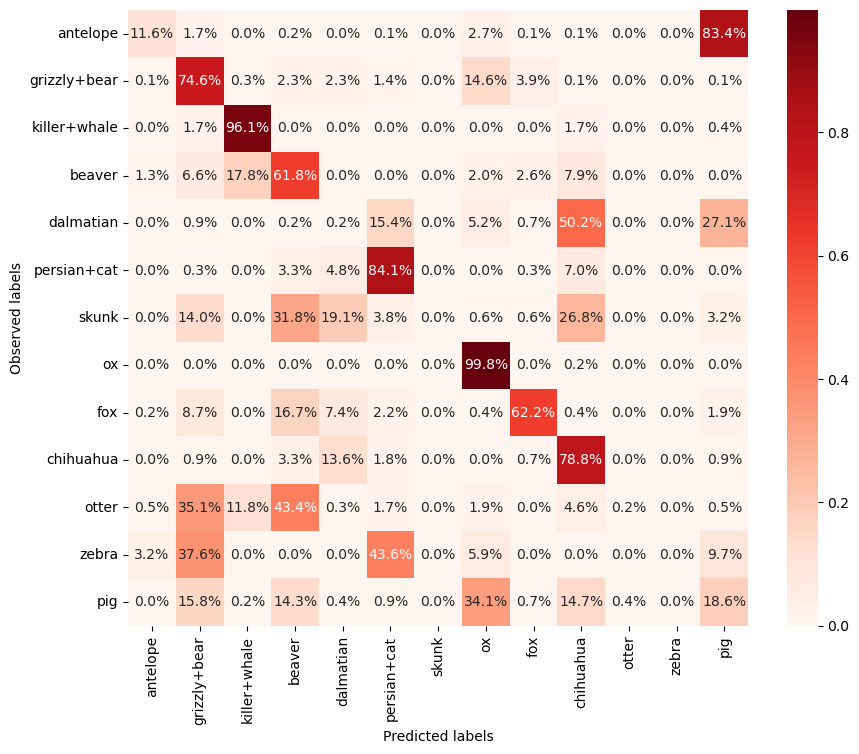

                precision    recall  f1-score   support

  ARTIODACTYLA       0.77      0.87      0.82      2241
     CARNIVORA       0.73      0.77      0.75      3468
PERISSODACTYLA       0.00      0.00      0.00       942
      RODENTIA       0.15      0.62      0.24       152

      accuracy                           0.69      6803
     macro avg       0.41      0.56      0.45      6803
  weighted avg       0.63      0.69      0.66      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.86970103 0.76730104 0.         0.61842105]
Top_1_accuracy for UnSeen Validation split 01 -  0.5638557792553488


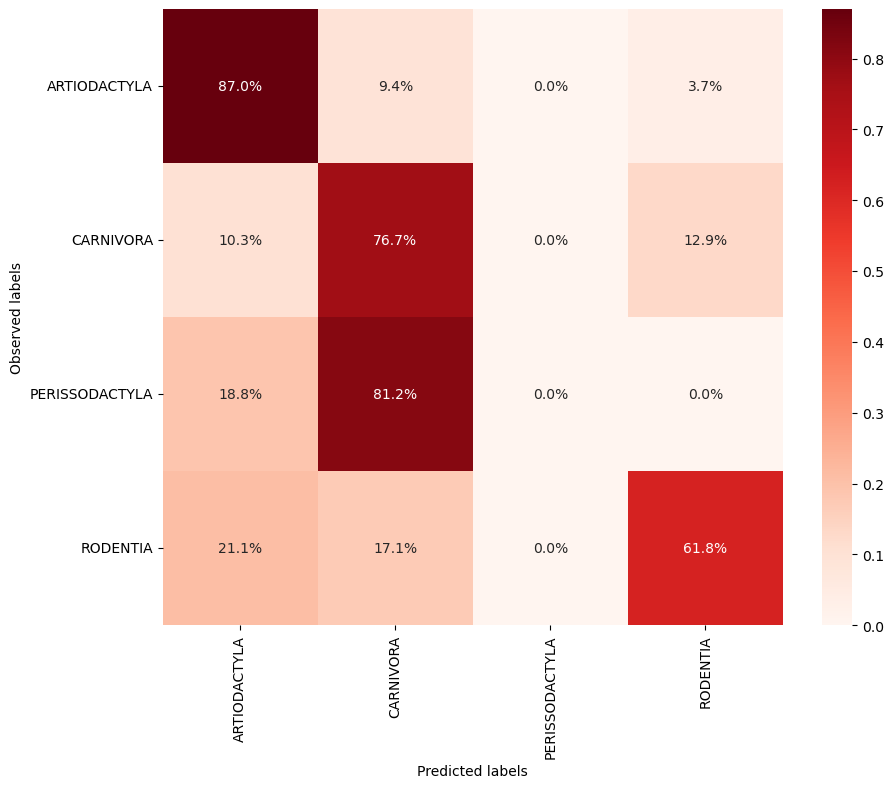

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.623768797859968 
               0         1
0       antelope  0.832176
1   grizzly+bear  0.831884
2   killer+whale  0.978355
3         beaver  0.690789
4      dalmatian  0.416290
5    persian+cat  0.876461
6          skunk  0.000000
7             ox  0.998299
8            fox  0.855556
9      chihuahua  0.970982
10         otter  0.050676
11         zebra  0.000000
12           pig  0.607527 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.720423520708773 
               0         1
0       antelope  0.984954
1   grizzly+bear  0.891304
2   killer+whale  0.978355
3         beaver  0.723684
4      dalmatian  0.656109
5    persian+cat  0.931553
6          skunk  0.000000
7             ox  0.998299
8            fox  0.942593
9      chihuahua  0.984375
10         otter  0.538851
11         zebra  0.004246
12           pig  0.731183 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.7678964475941192 
               0         1
0    

In [16]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.3 Train Validation Split 03

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5423                0.5026        0.5191                0.5065     +  1.4911
      2        0.5108                0.5208        0.4970                0.5320     +  1.6884
      3        0.4825                0.5524        0.4641                0.5693     +  1.7338
      4        0.4472                0.5903        0.4288                0.6068     +  1.8996
      5        0.4131                0.6251        0.3971                0.6398     +  1.7822
      6        0.3833                0.6562        0.3694                0.6691     +  1.6861
      7        0.3573                0.6828        0.3450                0.6937     +  1.5555
      8        0.3344                0.7060        0.3235                0.7164     +  1.5419
      9        0.3143                0.7282    

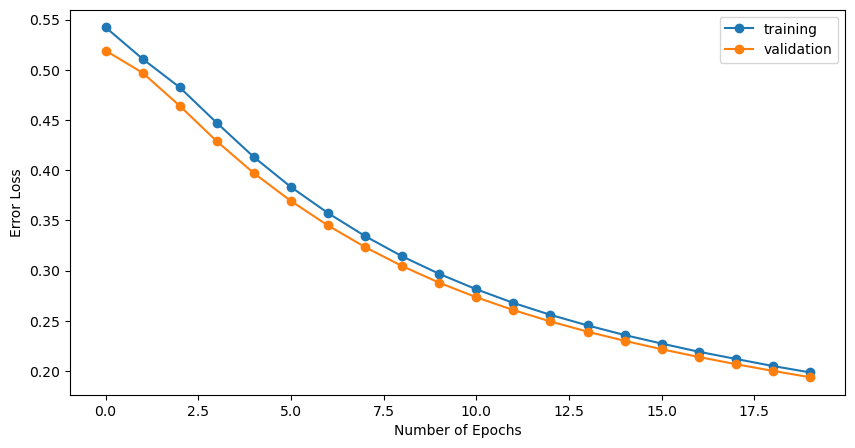

Trianing Recall Macro Curve


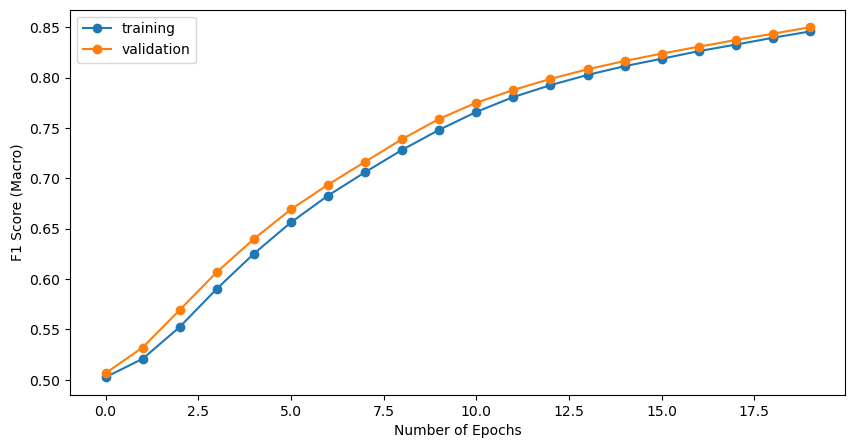

Recall (Macro)
0.8470569159129379
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.58      0.67      0.62       400
         moose       0.53      0.52      0.52       554
humpback+whale       1.00      0.59      0.74       565
    chimpanzee       0.88      0.93      0.91       566
      squirrel       0.41      0.77      0.54       961
    rhinoceros       0.91      0.37      0.52       561
        rabbit       0.00      0.00      0.00       877
          wolf       0.36      0.34      0.35       470
     chihuahua       0.37      0.93      0.53       448
        weasel       0.36      0.05      0.09       222
   giant+panda       0.68      0.94      0.79       692
           pig       0.36      0.51      0.42       558
       raccoon       0.00      0.00      0.00       408

      accuracy                           0.53      7282
     macro avg       0.50      0.51      0.46      7282
  weighted avg       0.49      0.53      0.48      7282

Top_1_accuracy for UnSeen Validation split 01

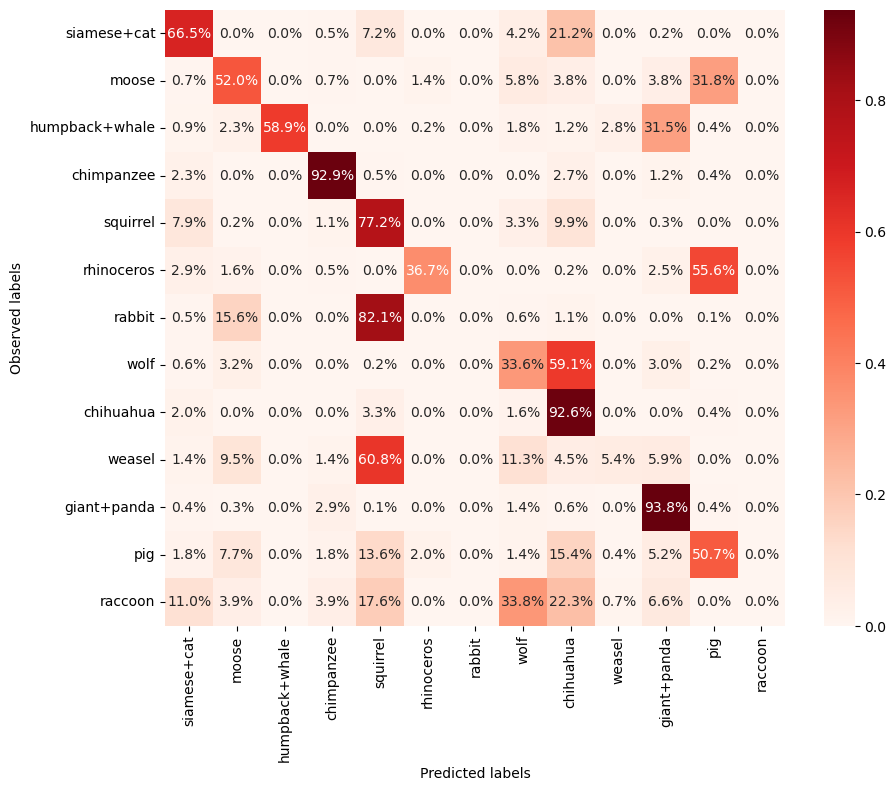

                precision    recall  f1-score   support

  ARTIODACTYLA       0.69      0.68      0.68      1677
     CARNIVORA       0.76      0.87      0.81      2640
    LAGOMORPHA       0.00      0.00      0.00       877
PERISSODACTYLA       0.91      0.37      0.52       561
      PRIMATES       0.88      0.93      0.91       566
      RODENTIA       0.41      0.77      0.54       961

      accuracy                           0.67      7282
     macro avg       0.61      0.60      0.58      7282
  weighted avg       0.63      0.67      0.63      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.67859273 0.86590909 0.         0.36720143 0.92932862 0.77211238]
Top_1_accuracy for UnSeen Validation split 01 -  0.6021907078134949


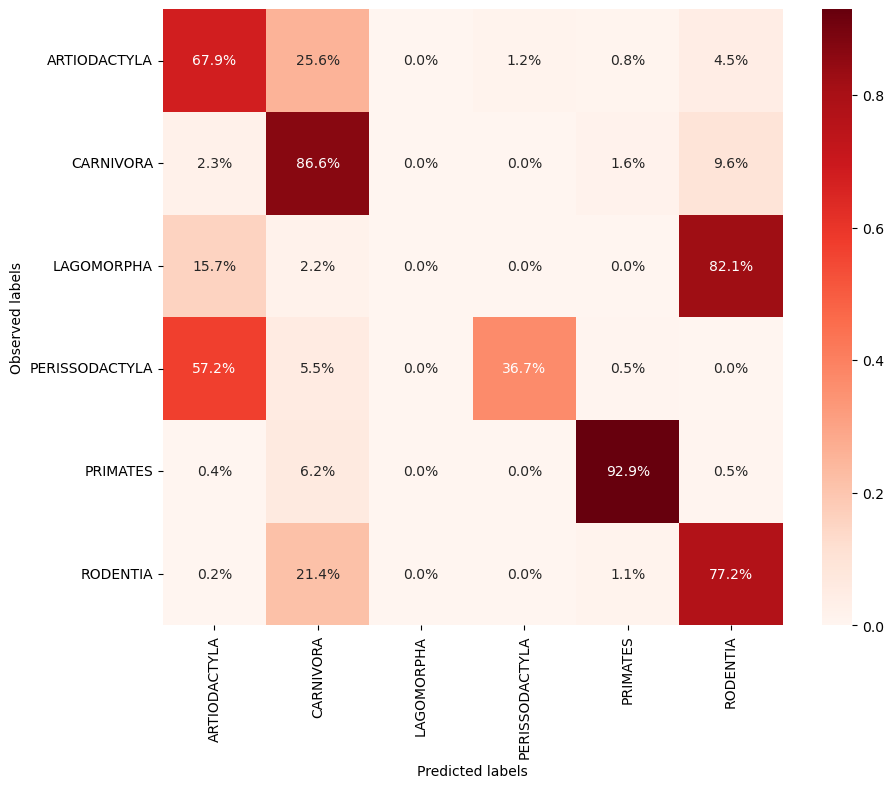

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.660858253412266 
                 0         1
0      siamese+cat  0.785000
1            moose  0.862816
2   humpback+whale  0.853097
3       chimpanzee  0.959364
4         squirrel  0.868887
5       rhinoceros  0.554367
6           rabbit  0.025086
7             wolf  0.968085
8        chihuahua  0.977679
9           weasel  0.171171
10     giant+panda  0.971098
11             pig  0.589606
12         raccoon  0.004902 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7310393834251179 
                 0         1
0      siamese+cat  0.932500
1            moose  0.913357
2   humpback+whale  0.923894
3       chimpanzee  0.980565
4         squirrel  0.939646
5       rhinoceros  0.647059
6           rabbit  0.229190
7             wolf  0.980851
8        chihuahua  0.988839
9           weasel  0.270270
10     giant+panda  0.984104
11             pig  0.666667
12         raccoon  0.046569 

 Top- 4  Accuracy per class 
 Top- 4  Accurac

In [17]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 9. Hyperoptimisation

In [16]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.Sigmoid())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, kg_vec))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 4, 64)
    ep = trial.suggest_int("max_epoch", 5, 50)
    mom = trial.suggest_loguniform('optimizer__momentum', .90, .99)
   
       
    hyper_net1 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict_proba(ValData01.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob1 = []
    for y in y_pred_unseen1:
        y_pred_unseen_prob1.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,-kg_vec:])
    animal_attributes_labels1 = predicatedf_CZSL1['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosine Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen_prob1, animal_attributes1, 'cosine'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['labels'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict_proba(ValData02.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob2 = []
    for y in y_pred_unseen2:
        y_pred_unseen_prob2.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,-kg_vec:])
    animal_attributes_labels2 = predicatedf_CZSL2['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen_prob2, animal_attributes2, 'cosine'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['labels'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict_proba(ValData03.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob3 = []
    for y in y_pred_unseen3:
        y_pred_unseen_prob3.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,-kg_vec:])
    animal_attributes_labels3 = predicatedf_CZSL3['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen_prob3, animal_attributes3, 'cosine'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['labels'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [17]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="DNN with KG.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-10 01:18:52,823] A new study created in memory with name: no-name-152c8c74-c83f-4251-84cb-287ce679d430


Sequential(
  (0): Linear(in_features=2048, out_features=14, bias=True)
  (1): Dropout(p=0.15737529291457475, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=14, out_features=183, bias=True)
  (4): Dropout(p=0.15737529291457475, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=183, out_features=600, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=14, bias=True)
  (1): Dropout(p=0.15737529291457475, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=14, out_features=183, bias=True)
  (4): Dropout(p=0.15737529291457475, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=183, out_features=600, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=14, bias=True)
  (1): Dropout(p=0.15737529291457475, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=14, out_features=183, bias=True)
  (4): Dropout(p=0.15737529291457475, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=183, out_features=600, bias=True)
)
 

     15        0.3991        0.3913                0.6593  0.9651
     16        0.3918        0.3826                0.6725  1.2529
     17        0.3836        0.3737                0.6830  1.1970
     18        0.3757        0.3657                0.6899  1.1759
     19        0.3685        0.3593                0.6977  1.1253
     20        0.3621        0.3535                0.7015  0.9935
     21        0.3563        0.3479                0.7071  1.0556
     22        0.3505        0.3430                0.7157  1.0009
     23        0.3448        0.3372                0.7220  0.9530
     24        0.3398        0.3314                0.7260  0.9599
     25        0.3348        0.3261                0.7298  1.1049
     26        0.3294        0.3204                0.7349  0.9390
     27        0.3240        0.3162                0.7405  1.0485
     28        0.3194        0.3117                0.7451  0.8677
     29        0.3150        0.3069                0.7526  1.0230
     30   

[I 2022-12-10 01:21:06,401] Trial 0 finished with value: 0.3133927970052941 and parameters: {'lr': 0.030600825065739884, 'batch_size': 50, 'max_epoch': 30, 'optimizer__momentum': 0.9838932168514112, 'n_layers': 2, 'dropout': 0.15737529291457475, 'n_units_l0': 14, 'n_units_l1': 183}. Best is trial 0 with value: 0.3133927970052941.


[0.27064099683559995, 0.2751020962893048, 0.3944352978909776]
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.49831937984354224, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=6, out_features=44, bias=True)
  (4): Dropout(p=0.49831937984354224, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=44, out_features=99, bias=True)
  (7): Dropout(p=0.49831937984354224, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=99, out_features=600, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.49831937984354224, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=6, out_features=44, bias=True)
  (4): Dropout(p=0.49831937984354224, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=44, out_features=99, bias=True)
  (7): Dropout(p=0.49831937984354224, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=99, out_features=600, bias=True)
)
Sequential(
  (0): Linea

[I 2022-12-10 01:32:49,692] Trial 1 finished with value: 0.19128613368480485 and parameters: {'lr': 0.11276512225338746, 'batch_size': 4, 'max_epoch': 25, 'optimizer__momentum': 0.971692613592541, 'n_layers': 3, 'dropout': 0.49831937984354224, 'n_units_l0': 6, 'n_units_l1': 44, 'n_units_l2': 99}. Best is trial 0 with value: 0.3133927970052941.


[0.18242156737439125, 0.15980537227358912, 0.23163146140643415]
Sequential(
  (0): Linear(in_features=2048, out_features=172, bias=True)
  (1): Dropout(p=0.36082940450835976, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=172, out_features=4, bias=True)
  (4): Dropout(p=0.36082940450835976, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=250, bias=True)
  (7): Dropout(p=0.36082940450835976, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=250, out_features=600, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=172, bias=True)
  (1): Dropout(p=0.36082940450835976, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=172, out_features=4, bias=True)
  (4): Dropout(p=0.36082940450835976, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=250, bias=True)
  (7): Dropout(p=0.36082940450835976, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=250, out_features=600, bias=True)
)
Sequential(
  

[I 2022-12-10 01:35:57,398] Trial 2 finished with value: 0.20241115828636924 and parameters: {'lr': 0.24343810338676358, 'batch_size': 14, 'max_epoch': 20, 'optimizer__momentum': 0.9692645073954756, 'n_layers': 3, 'dropout': 0.36082940450835976, 'n_units_l0': 172, 'n_units_l1': 4, 'n_units_l2': 250}. Best is trial 0 with value: 0.3133927970052941.


[0.2394783137586045, 0.1705918314050146, 0.19716332969548855]
Number of finished trials: 3
Best trial:
  Value: 0.3133927970052941
  Params: 
    lr: 0.030600825065739884
    batch_size: 50
    max_epoch: 30
    optimizer__momentum: 0.9838932168514112
    n_layers: 2
    dropout: 0.15737529291457475
    n_units_l0: 14
    n_units_l1: 183


# 10. CZSL on Unseen Test Set using Hyperoptiimsation parameters

In [17]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, 14)  
        self.fc2 = nn.Linear(14, 183) 
        self.fc3 = nn.Linear(183, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out   

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5395                0.4952        0.5298                0.4978     +  1.4165
      2        0.5306                0.4951        0.5289                0.4983     +  1.4053
      3        0.5296                0.4958        0.5276                0.4991     +  1.5218
      4        0.5279                0.4971        0.5255                0.4991     +  1.4465
      5        0.5248                0.4997        0.5208                0.5002     +  1.6770
      6        0.5169                0.5067        0.5083                0.5091     +  1.7203
      7        0.4979                0.5278        0.4827                0.5428     +  1.4678
      8        0.4730                0.5583        0.4615                0.5695     +  1.4492
      9        0.4560                0.5771    

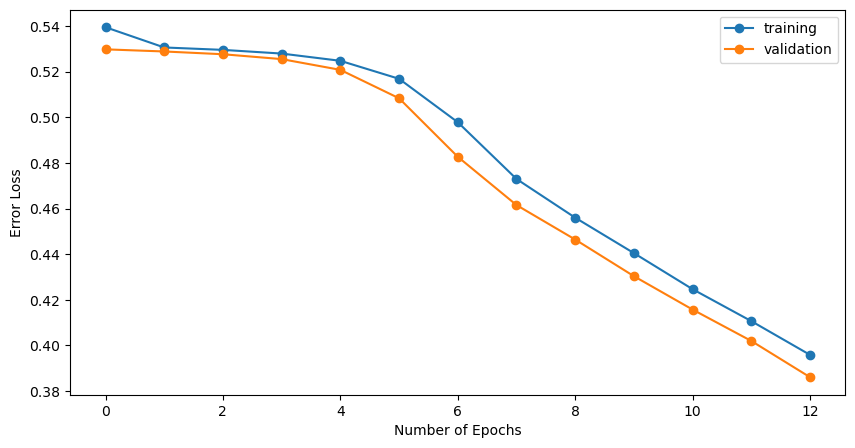

Trianing Recall Macro Curve


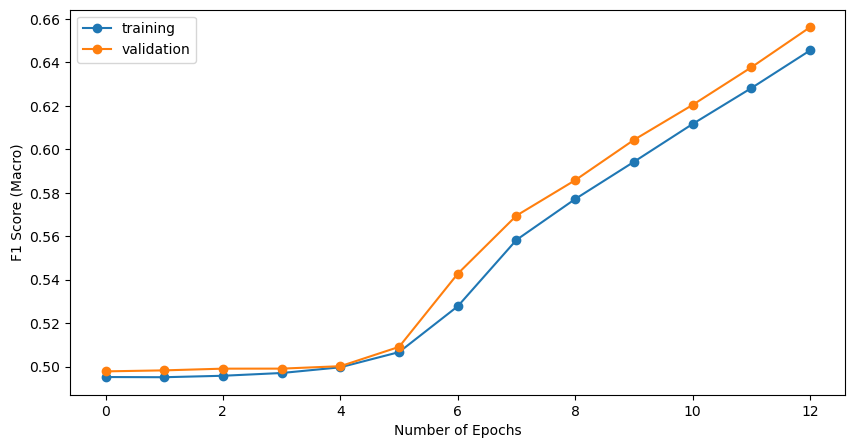

ValueError: loaded state dict contains a parameter group that doesn't match the size of optimizer's group

In [19]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork2, 
               epochs = 30, 
               bs = 50, 
               numunits = 0, 
               lr = 0.030600825065739884, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.15737529291457475, 
               mom = 0.9838932168514112, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5354                0.4896        0.5259                0.4824     +  1.2197
      2        0.5267                0.4889        0.5250                0.4844     +  1.6529
      3        0.5258                0.4895        0.5240                0.4837     +  1.2871
      4        0.5244                0.4907        0.5222                0.4868     +  1.6216
      5        0.5220                0.4928        0.5190                0.4912     +  1.1156
      6        0.5170                0.4979        0.5118                0.5003     +  1.6476
      7        0.5059                0.5094        0.4962                0.5141     +  1.3623
      8        0.4856                0.5293        0.4732                0.5386     +  1.6508
      9        0.4625                0.5541    

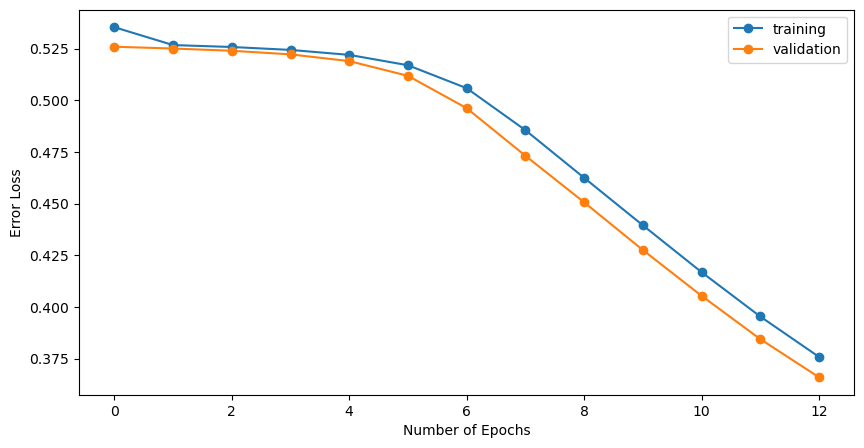

Trianing Recall Macro Curve


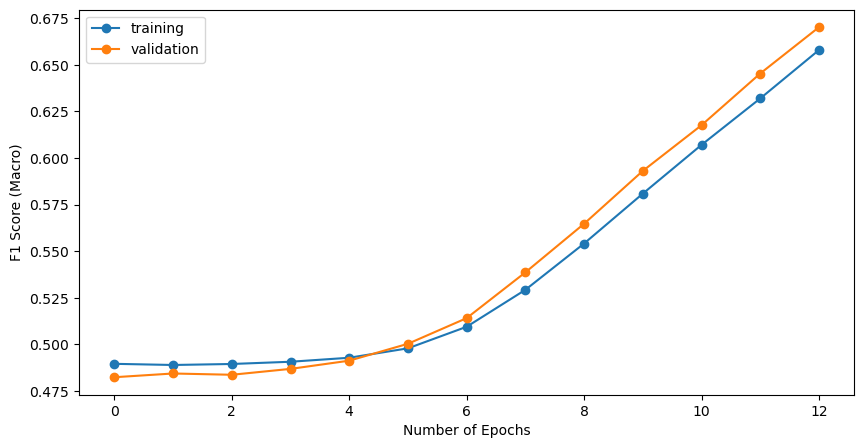

Recall (Macro)
0.6689450265670573
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.00      0.00      0.00       864
grizzly+bear       0.35      0.68      0.46       690
killer+whale       0.00      0.00      0.00       231
      beaver       0.15      0.64      0.24       152
   dalmatian       0.06      0.06      0.06       442
 persian+cat       0.45      0.53      0.48       599
       skunk       0.00      0.00      0.00       157
          ox       0.39      0.98      0.55       588
         fox       0.66      0.52      0.58       540
   chihuahua       0.20      0.33      0.25       448
       otter       0.00      0.00      0.00       592
       zebra       0.00      0.00      0.00       942
         pig       0.12      0.22      0.16       558

    accuracy                           0.30      6803
   macro avg       0.18      0.30      0.21      6803
weighted avg       0.19      0.30      0.22      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.682608

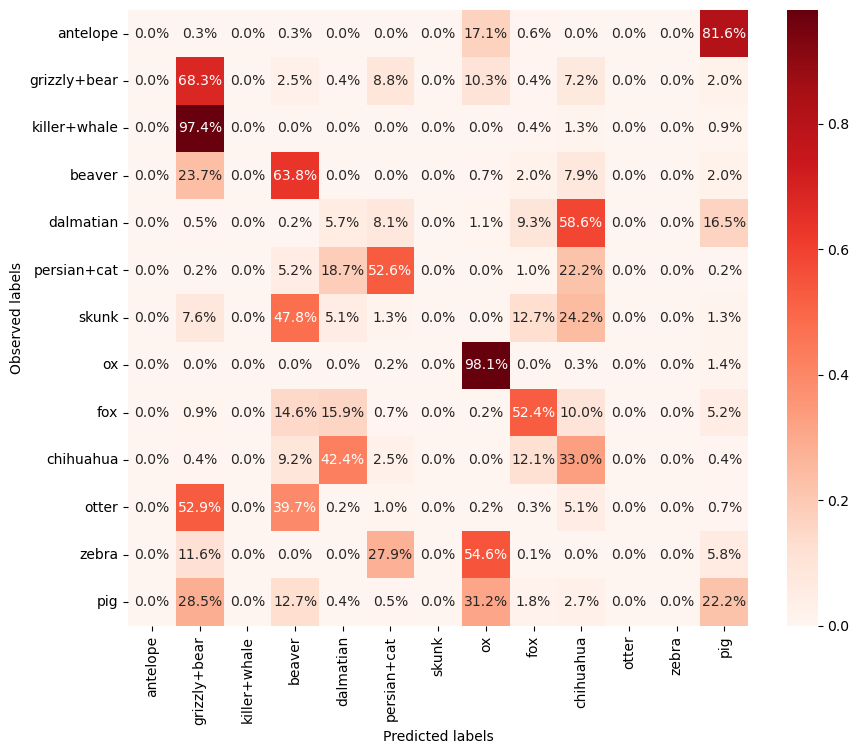

                precision    recall  f1-score   support

  ARTIODACTYLA       0.69      0.78      0.73      2241
     CARNIVORA       0.77      0.80      0.78      3468
PERISSODACTYLA       0.00      0.00      0.00       942
      RODENTIA       0.15      0.64      0.24       152

      accuracy                           0.68      6803
     macro avg       0.40      0.55      0.44      6803
  weighted avg       0.62      0.68      0.65      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.77554663 0.80363322 0.         0.63815789]
Top_1_accuracy for UnSeen Validation split 01 -  0.5543344359245599


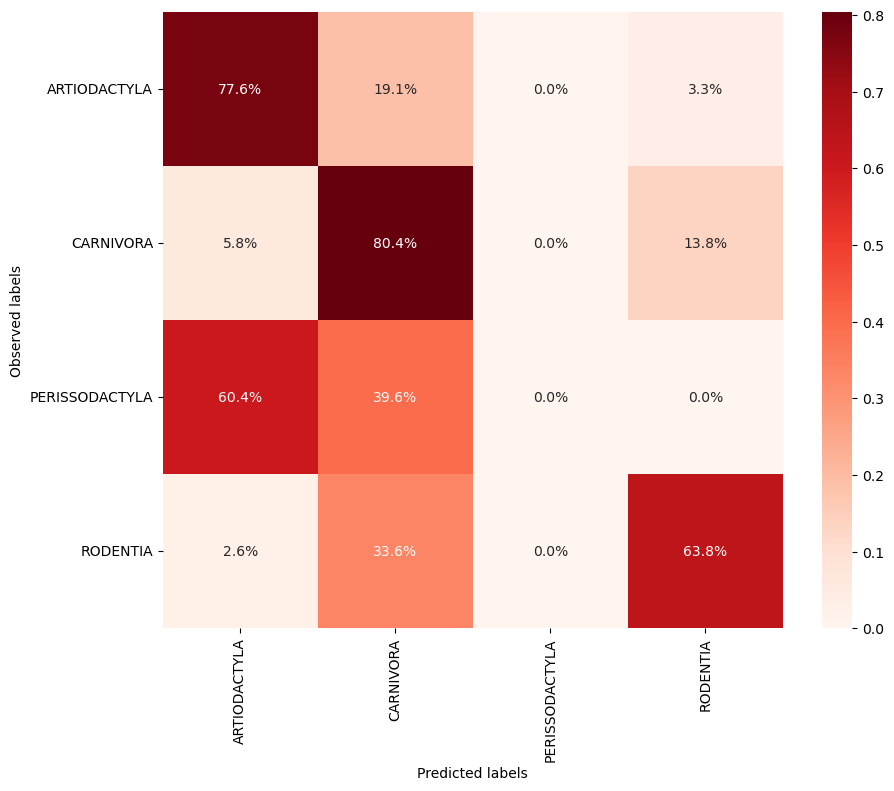

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.44066847686302935 
               0         1
0       antelope  0.000000
1   grizzly+bear  0.752174
2   killer+whale  0.000000
3         beaver  0.842105
4      dalmatian  0.328054
5    persian+cat  0.580968
6          skunk  0.000000
7             ox  0.994898
8            fox  0.724074
9      chihuahua  0.897321
10         otter  0.062500
11         zebra  0.000000
12           pig  0.546595 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.6360400492897293 
               0         1
0       antelope  0.953704
1   grizzly+bear  0.824638
2   killer+whale  0.008658
3         beaver  0.861842
4      dalmatian  0.699095
5    persian+cat  0.727880
6          skunk  0.000000
7             ox  0.994898
8            fox  0.957407
9      chihuahua  0.977679
10         otter  0.511824
11         zebra  0.000000
12           pig  0.750896 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.6875309417470287 
               0         1
0 

In [20]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork2, 
               epochs = 13, 
               bs = 34, 
               numunits = 0, 
               lr = 0.032045737317419054, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.15445606357703778, 
               mom = 0.9042552894432444, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5397                0.4973        0.5303                0.5016     +  1.3047
      2        0.5310                0.4971        0.5294                0.5013     +  1.4929
      3        0.5299                0.4979        0.5282                0.5022     +  1.2226
      4        0.5282                0.4995        0.5261                0.5030     +  1.5318
      5        0.5251                0.5029        0.5216                0.5051     +  1.1817
      6        0.5175                0.5122        0.5101                0.5177     +  1.5272
      7        0.4995                0.5340        0.4867                0.5437     +  1.2278
      8        0.4746                0.5587        0.4643                0.5652     +  1.5976
      9        0.4541                0.5776    

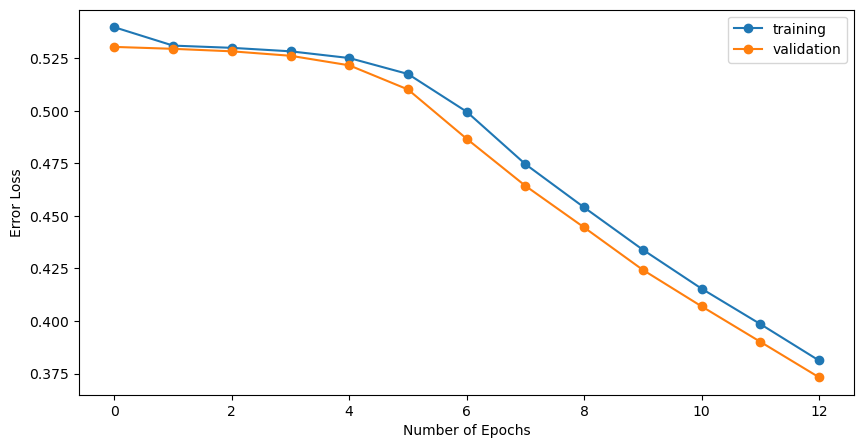

Trianing Recall Macro Curve


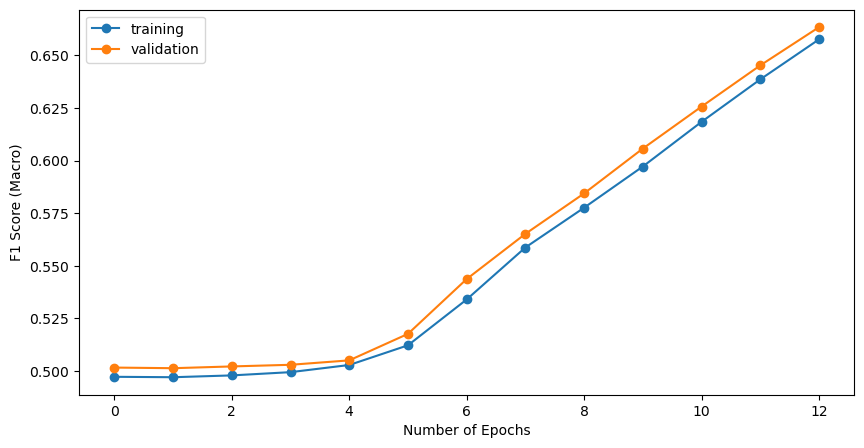

Recall (Macro)
0.6653652858209562
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.09      0.23      0.13       400
         moose       0.20      0.24      0.22       554
humpback+whale       0.00      0.00      0.00       565
    chimpanzee       0.00      0.00      0.00       566
      squirrel       0.15      0.01      0.03       961
    rhinoceros       0.00      0.00      0.00       561
        rabbit       0.00      0.00      0.00       877
          wolf       0.03      0.06      0.04       470
     chihuahua       0.24      0.96      0.38       448
        weasel       0.00      0.00      0.00       222
   giant+panda       0.32      0.80      0.46       692
           pig       0.22      0.37      0.28       558
       raccoon       0.00      0.00      0.00       408

      accuracy                           0.20      7282
     macro avg       0.10      0.21      0.12      7282
  weighted avg       0.10      0.20      0.12      7282

Top_1_accuracy for UnSeen Validation split 01

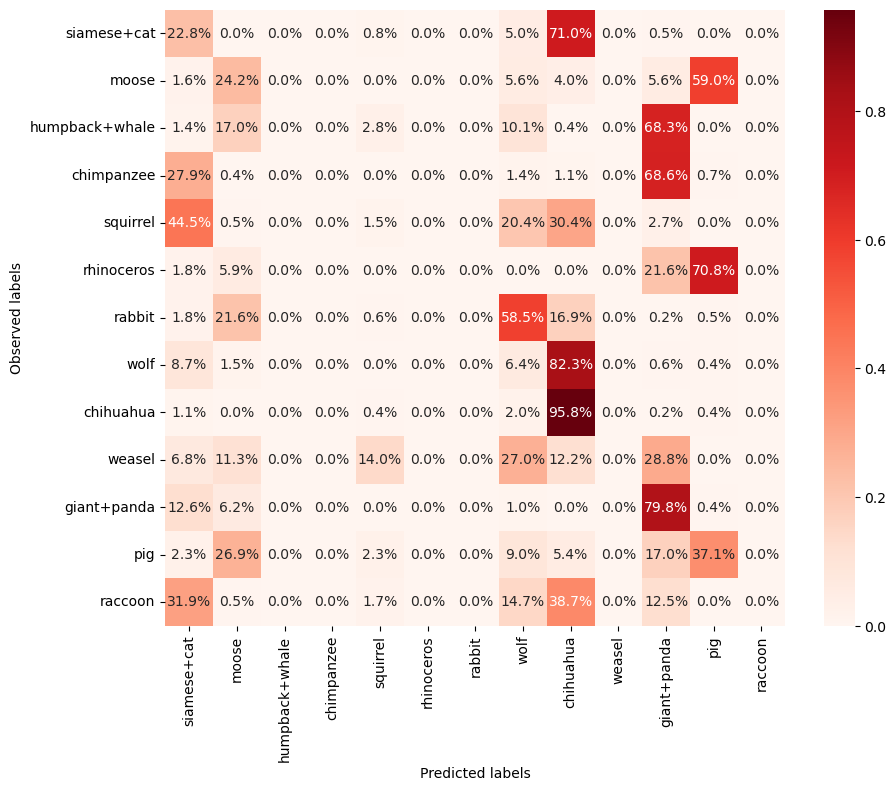

                precision    recall  f1-score   support

  ARTIODACTYLA       0.56      0.55      0.55      1677
     CARNIVORA       0.45      0.95      0.61      2640
    LAGOMORPHA       0.00      0.00      0.00       877
PERISSODACTYLA       0.00      0.00      0.00       561
      PRIMATES       0.00      0.00      0.00       566
      RODENTIA       0.15      0.01      0.03       961

      accuracy                           0.47      7282
     macro avg       0.19      0.25      0.20      7282
  weighted avg       0.31      0.47      0.35      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.54502087 0.95189394 0.         0.         0.         0.01456816]
Top_1_accuracy for UnSeen Validation split 01 -  0.2519138280274633


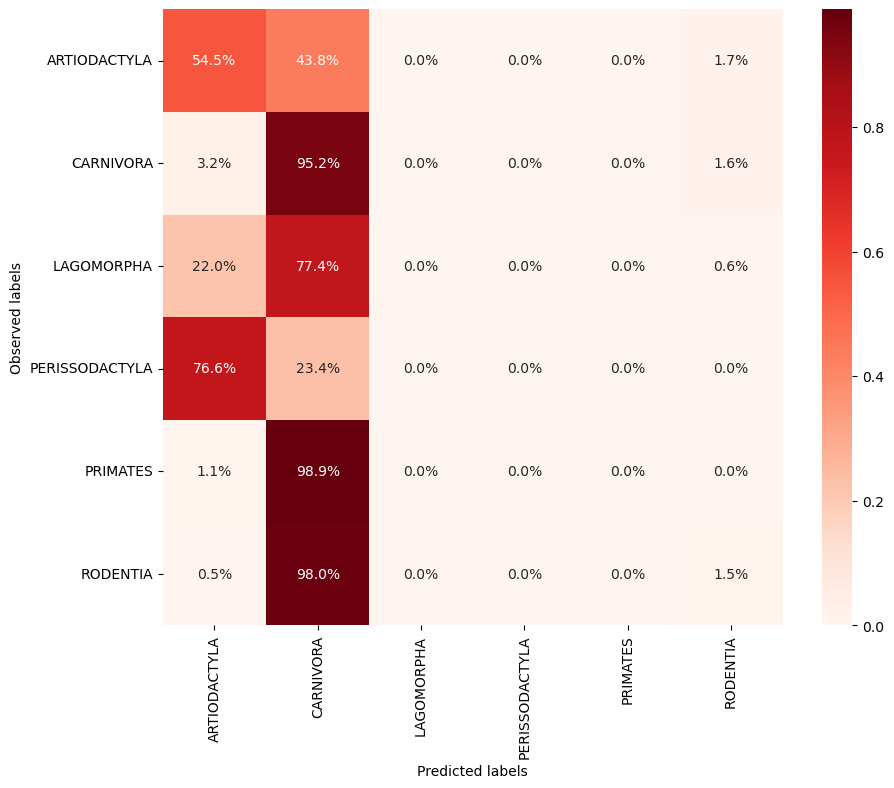

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.39465845419081813 
                 0         1
0      siamese+cat  0.487500
1            moose  0.873646
2   humpback+whale  0.000000
3       chimpanzee  0.365724
4         squirrel  0.064516
5       rhinoceros  0.092692
6           rabbit  0.002281
7             wolf  0.812766
8        chihuahua  0.984375
9           weasel  0.000000
10     giant+panda  0.877168
11             pig  0.569892
12         raccoon  0.000000 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.503893832187154 
                 0         1
0      siamese+cat  0.960000
1            moose  0.897112
2   humpback+whale  0.000000
3       chimpanzee  0.768551
4         squirrel  0.155047
5       rhinoceros  0.160428
6           rabbit  0.063854
7             wolf  0.978723
8        chihuahua  0.993304
9           weasel  0.000000
10     giant+panda  0.924855
11             pig  0.648746
12         raccoon  0.000000 

 Top- 4  Accuracy per class 
 Top- 4  Accura

In [21]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork2, 
               epochs = 13, 
               bs = 34, 
               numunits = 0, 
               lr = 0.032045737317419054, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.15445606357703778, 
               mom = 0.9042552894432444, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5592                0.5006        0.5344                0.5065     +  1.4549
      2        0.5343                0.5028        0.5267                0.5111     +  1.4548
      3        0.5193                0.5190        0.5026                0.5359     +  1.6741
      4        0.4909                0.5496        0.4736                0.5588     +  1.5335
      5        0.4665                0.5732        0.4512                0.5863     +  1.5250
      6        0.4472                0.5970        0.4322                0.6094     +  1.5331
      7        0.4315                0.6145        0.4162                0.6270     +  1.4546
      8        0.4195                0.6281        0.4041                0.6394     +  1.4314
      9        0.4098                0.6386    

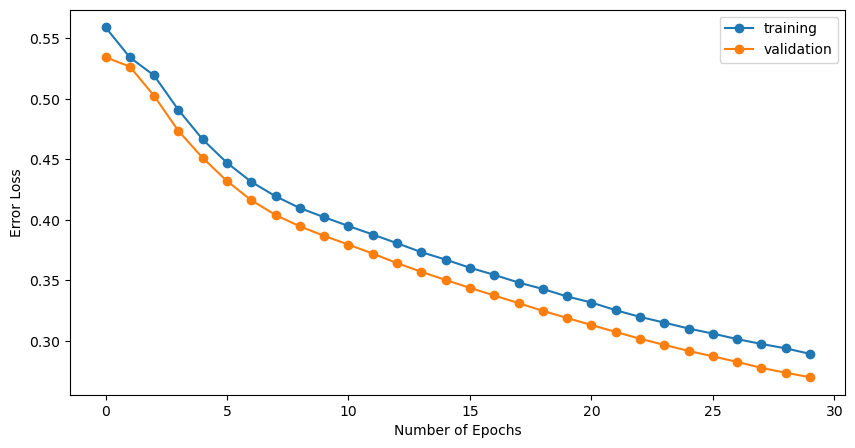

Trianing Recall Macro Curve


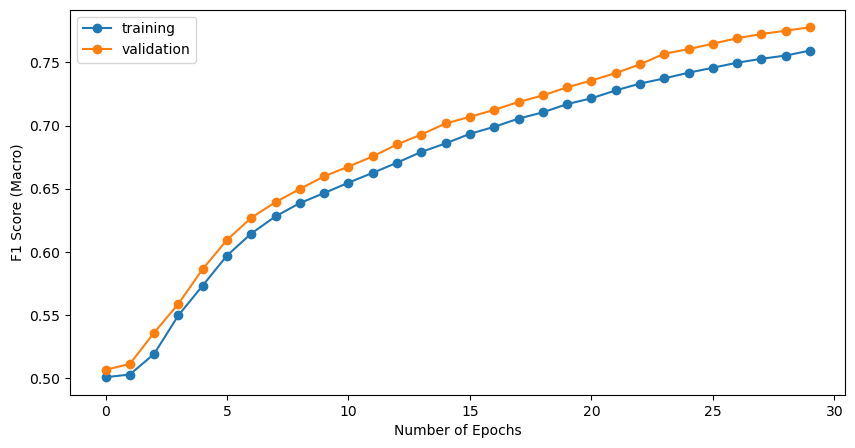

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.13      0.01      0.02      1645
  blue+whale       0.10      1.00      0.18       174
       sheep       0.38      0.88      0.53      1420
        seal       0.00      0.00      0.00       988
         bat       0.00      0.00      0.00       383
     giraffe       0.01      0.01      0.01      1202
         rat       0.44      0.91      0.60       310
      bobcat       0.40      0.95      0.56       630
      walrus       0.05      0.02      0.03       215
     dolphin       0.00      0.00      0.00       946

    accuracy                           0.29      7913
   macro avg       0.15      0.38      0.19      7913
weighted avg       0.15      0.29      0.17      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.01155015 1.         0.87746479 0.         0.         0.00582363
 0.90645161 0.95238095 0.01860465 0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.3772275784442901


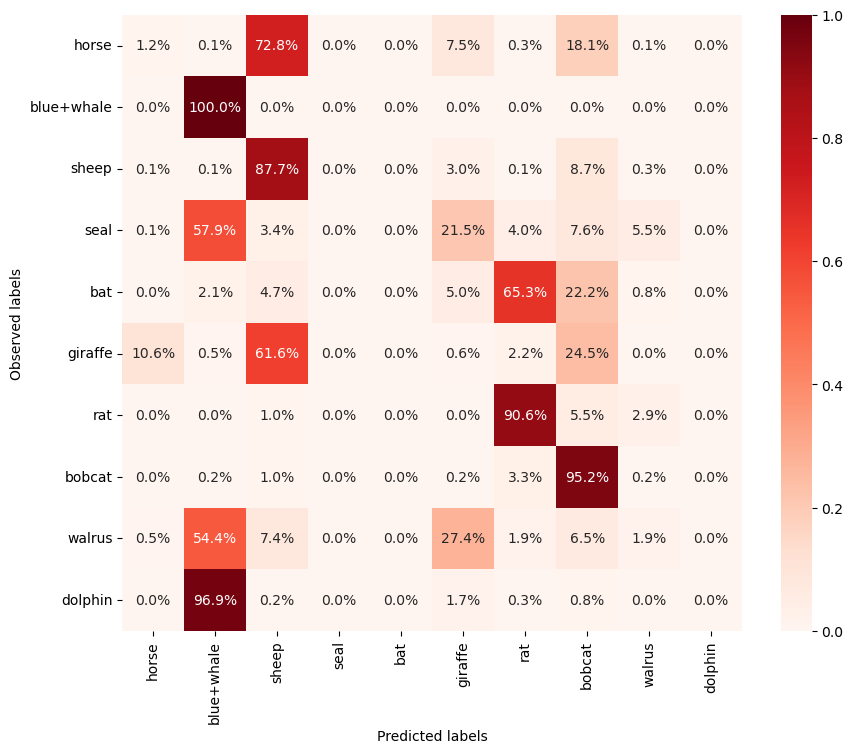

                precision    recall  f1-score   support

  ARTIODACTYLA       0.57      0.84      0.68      3742
     CARNIVORA       0.47      0.41      0.44      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.13      0.01      0.02      1645
      RODENTIA       0.44      0.91      0.60       310

      accuracy                           0.53      7913
     macro avg       0.32      0.43      0.35      7913
  weighted avg       0.42      0.53      0.45      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.8423303  0.4080742  0.         0.01155015 0.90645161]
Top_1_accuracy for UnSeen Validation split 01 -  0.4336812529674135


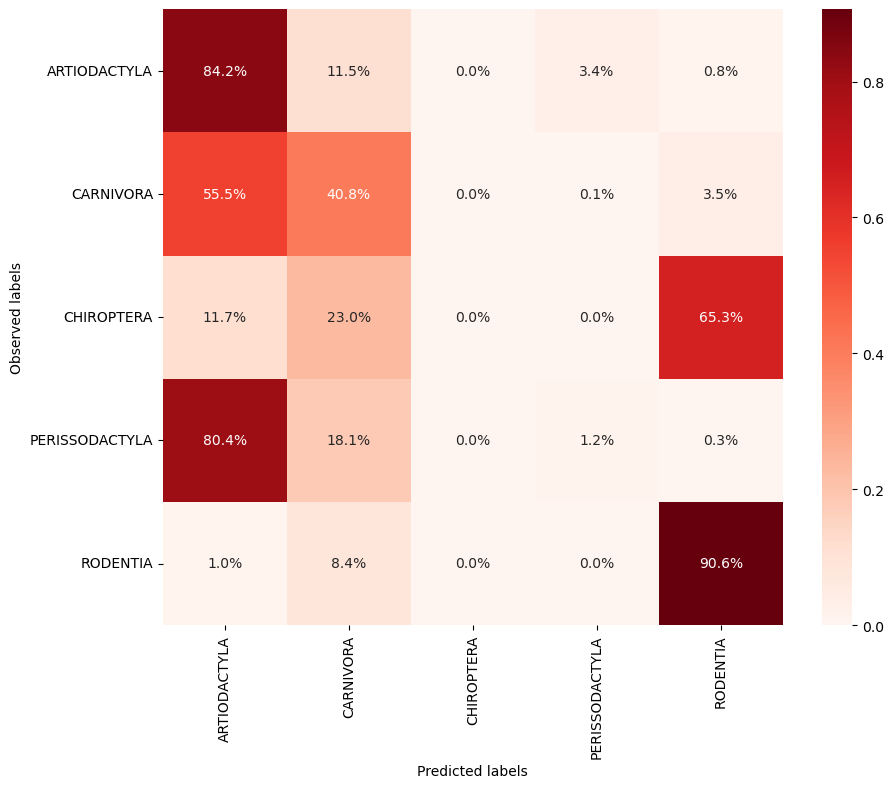

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.5751184863918434 
            0         1
0       horse  0.677812
1  blue+whale  1.000000
2       sheep  0.958451
3        seal  0.000000
4         bat  0.000000
5     giraffe  0.048253
6         rat  0.961290
7      bobcat  0.988889
8      walrus  0.153488
9     dolphin  0.963002 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.6393874935235468 
            0         1
0       horse  0.787234
1  blue+whale  1.000000
2       sheep  0.974648
3        seal  0.000000
4         bat  0.023499
5     giraffe  0.105657
6         rat  0.967742
7      bobcat  1.000000
8      walrus  0.548837
9     dolphin  0.986258 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.7241881550505134 
            0         1
0       horse  0.873556
1  blue+whale  1.000000
2       sheep  0.985915
3        seal  0.000000
4         bat  0.334204
5     giraffe  0.252080
6         rat  0.970968
7      bobcat  1.000000
8      walrus  0.832558
9     dolphin  0.9

In [18]:
Test01 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork2, 
               epochs = 30, 
               bs = 50, 
               numunits = 0, 
               lr = 0.030600825065739884, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.15737529291457475, 
               mom = 0.9838932168514112, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

 # 11. CZSL on Unseen Test Set using non optimised parameters

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5409                0.5064        0.5189                0.5185     +  4.0814
      2        0.5074                0.5334        0.4859                0.5552     +  2.5943
      3        0.4683                0.5750        0.4451                0.5975     +  2.5760
      4        0.4288                0.6177        0.4088                0.6372     +  2.6994
      5        0.3950                0.6552        0.3780                0.6707     +  2.5783
      6        0.3665                0.6854        0.3522                0.6974     +  2.4298
      7        0.3428                0.7100        0.3307                0.7188     +  2.5177
      8        0.3230                0.7302        0.3128                0.7371     +  2.5871
      9        0.3064                0.7473    

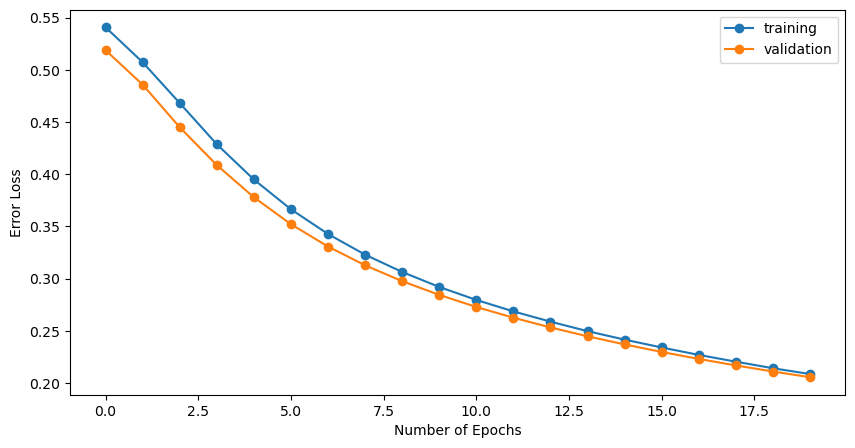

Trianing Recall Macro Curve


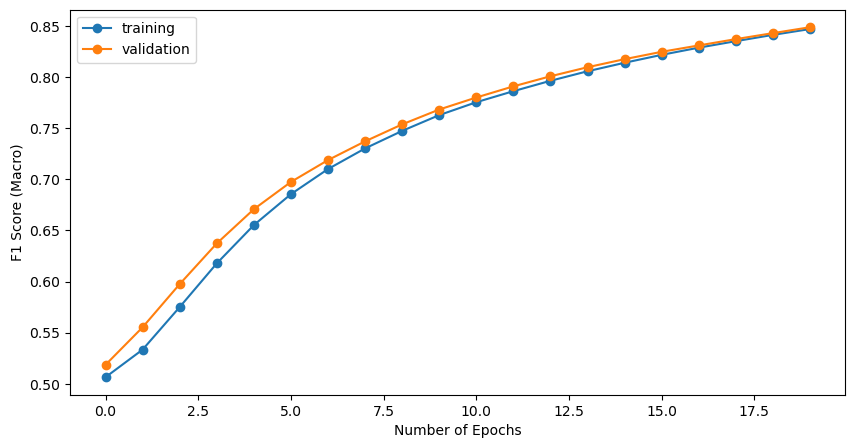

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.03      0.00      0.00      1645
  blue+whale       0.10      1.00      0.18       174
       sheep       0.43      0.96      0.59      1420
        seal       0.00      0.00      0.00       988
         bat       0.00      0.00      0.00       383
     giraffe       0.01      0.00      0.01      1202
         rat       0.51      0.93      0.66       310
      bobcat       0.36      0.98      0.52       630
      walrus       0.03      0.01      0.02       215
     dolphin       0.00      0.00      0.00       946

    accuracy                           0.31      7913
   macro avg       0.15      0.39      0.20      7913
weighted avg       0.13      0.31      0.18      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [6.07902736e-04 1.00000000e+00 9.56338028e-01 0.00000000e+00
 0.00000000e+00 4.15973378e-03 9.29032258e-01 9.79365079e-01
 1.39534884e-02 0.00000000e+00]
Top_1_accuracy for UnSeen Va

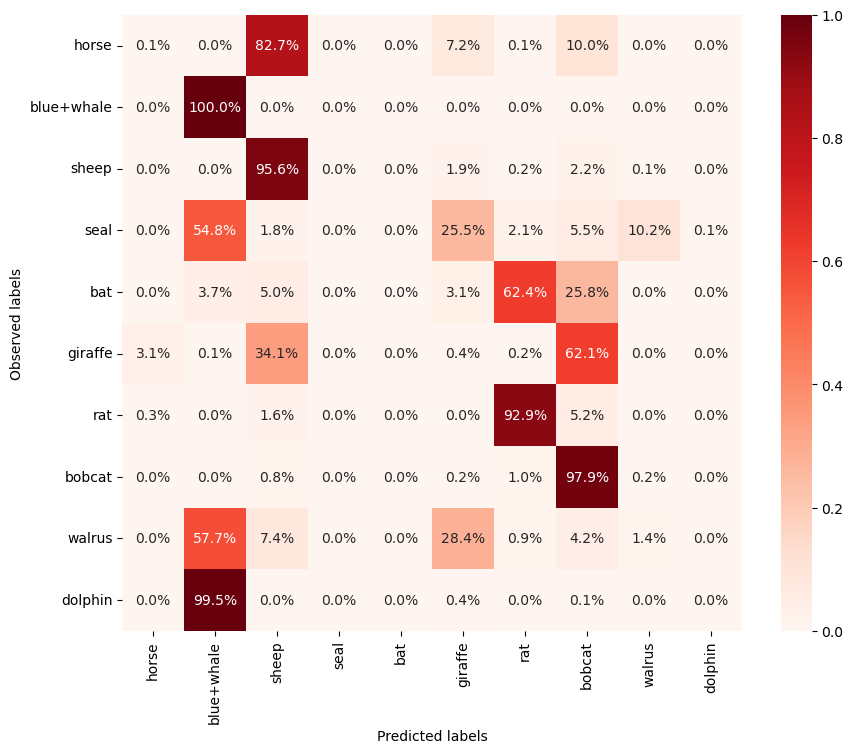

                precision    recall  f1-score   support

  ARTIODACTYLA       0.53      0.78      0.63      3742
     CARNIVORA       0.43      0.43      0.43      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.03      0.00      0.00      1645
      RODENTIA       0.51      0.93      0.66       310

      accuracy                           0.50      7913
     macro avg       0.30      0.43      0.34      7913
  weighted avg       0.38      0.50      0.42      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [7.80331374e-01 4.28259684e-01 0.00000000e+00 6.07902736e-04
 9.29032258e-01]
Top_1_accuracy for UnSeen Validation split 01 -  0.4276462435951836


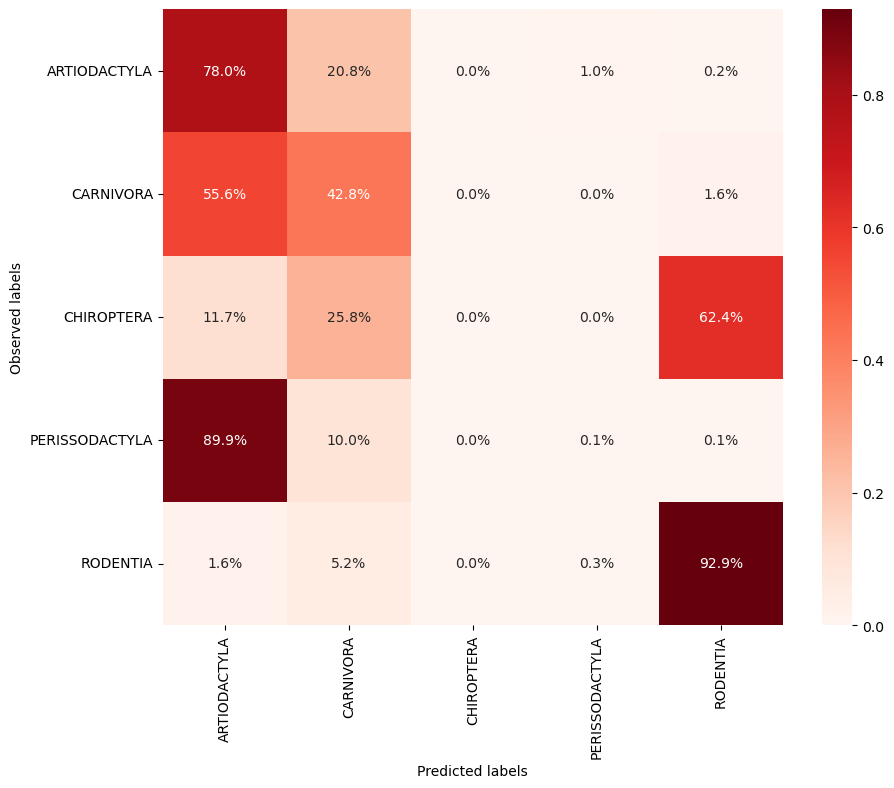

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.5524793029647717 
            0         1
0       horse  0.385410
1  blue+whale  1.000000
2       sheep  0.991549
3        seal  0.000000
4         bat  0.000000
5     giraffe  0.031614
6         rat  0.990323
7      bobcat  0.998413
8      walrus  0.134884
9     dolphin  0.992600 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.6502913994463158 
            0         1
0       horse  0.701520
1  blue+whale  1.000000
2       sheep  0.995775
3        seal  0.000000
4         bat  0.039164
5     giraffe  0.120632
6         rat  0.996774
7      bobcat  1.000000
8      walrus  0.651163
9     dolphin  0.997886 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.7523474669527166 
            0         1
0       horse  0.920973
1  blue+whale  1.000000
2       sheep  1.000000
3        seal  0.015182
4         bat  0.190601
5     giraffe  0.503328
6         rat  0.996774
7      bobcat  1.000000
8      walrus  0.897674
9     dolphin  0.9

In [15]:
Test02 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard